In [3]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/commit_test_folder/EECE491-01-Capstone-Design')

Mounted at /content/drive


In [4]:
# This cell prepares the Colab environment by copying and
# extracting the dataset from Google Drive to the fast local SSD.

import os
import time

# --- Part 1: Colab Local Data Setup ---
print("Starting data setup...")
start_setup_time = time.time()

# --- Define paths ---
DRIVE_ARCHIVE_PATH = "/content/drive/MyDrive/datasets/cropped_celeba.tar"
LOCAL_ARCHIVE_PATH = "/content/cropped_celeba.tar"
EXTRACT_PATH = "/content/celeba_dataset"

# The final, correct path to the images, based on our investigation
LOCAL_DATA_DIR = os.path.join(EXTRACT_PATH, "content", "cropped_celeba")

# --- Logic ---
# Only copy/untar if the local data directory doesn't already exist
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"Copying {DRIVE_ARCHIVE_PATH} to local runtime...")
    if not os.path.exists(DRIVE_ARCHIVE_PATH):
        print(f"[FATAL ERROR] Source file not found: {DRIVE_ARCHIVE_PATH}")
        raise FileNotFoundError(f"Source file not found: {DRIVE_ARCHIVE_PATH}")

    # 1. Copy the single .tar file from Drive (fast)
    !cp "{DRIVE_ARCHIVE_PATH}" "{LOCAL_ARCHIVE_PATH}"
    print("Copy complete.")

    # 2. Extract the archive to the local SSD (fast)
    print(f"Untarring {LOCAL_ARCHIVE_PATH} to {EXTRACT_PATH}...")
    !mkdir -p "{EXTRACT_PATH}"
    !tar -xf "{LOCAL_ARCHIVE_PATH}" -C "{EXTRACT_PATH}"
    print("Untar complete.")

    # 3. Clean up the local archive to save space
    !rm "{LOCAL_ARCHIVE_PATH}"
else:
    print(f"Data directory {LOCAL_DATA_DIR} already exists. Skipping copy/untar.")

print(f"Data setup finished in {time.time() - start_setup_time:.2f} seconds.")

# --- Sanity Check ---
# Crucial check to ensure data exists before proceeding
if not os.path.exists(LOCAL_DATA_DIR):
    print(f"\n[FATAL ERROR] The expected data directory does not exist: {LOCAL_DATA_DIR}")
    raise FileNotFoundError(f"Could not find data at {LOCAL_DATA_DIR}")
else:
    print(f"Successfully found data at: {LOCAL_DATA_DIR}")

Starting data setup...
Copying /content/drive/MyDrive/datasets/cropped_celeba.tar to local runtime...
Copy complete.
Untarring /content/cropped_celeba.tar to /content/celeba_dataset...
Untar complete.
Data setup finished in 34.31 seconds.
Successfully found data at: /content/celeba_dataset/content/cropped_celeba


In [5]:
import torch
# Import the function from the data_utils.py file we created
from data_utils import get_dataloaders

# --- Configuration ---
# Use the local data path defined in Cell 1
DATA_ROOT = LOCAL_DATA_DIR
BATCH_SIZE = 256
IMAGE_SIZE = 128
RANDOM_SEED = 42

# --- 1. Get Dataloaders ---
# This single function call does all the work
train_loader, val_loader, test_loader = get_dataloaders(
    root_dir=DATA_ROOT,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    random_seed=RANDOM_SEED
)

# --- 2. Verification ---
# Final check to ensure the dataloader works
if train_loader:
    print("\nVerifying one batch from train_loader...")
    try:
        # Get one sample batch
        images, labels = next(iter(train_loader))
        print(f"  Batch loaded successfully.")
        print(f"  Image batch shape: {images.shape}")
        print("\nSetup complete. You are ready to start training.")
    except Exception as e:
        print(f"  [Error] Failed to load batch: {e}")
else:
    print("\nData loading failed. Please check previous cell output.")


Loading dataset from: /content/celeba_dataset/content/cropped_celeba
Searching for '*.jpg' files in: /content/celeba_dataset/content/cropped_celeba
Successfully found 199509 images.
Successfully loaded 199509 total images.
Splitting dataset into:
  Train: 159607 images
  Validation: 19950 images
  Test: 19952 images

DataLoaders created successfully.

Verifying one batch from train_loader...
  Batch loaded successfully.
  Image batch shape: torch.Size([256, 3, 128, 128])

Setup complete. You are ready to start training.


Using device: cuda
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 220MB/s]


Starting robust training (L1 Loss)...
Epoch [1/20], Train Loss: 0.211907, Val Loss: 0.169275
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1.pth
Epoch [2/20], Train Loss: 0.131006, Val Loss: 0.119475
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1.pth
Epoch [3/20], Train Loss: 0.115245, Val Loss: 0.112074
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1.pth
Epoch [4/20], Train Loss: 0.107269, Val Loss: 0.142448
Epoch [5/20], Train Loss: 0.103621, Val Loss: 0.102914
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1.pth
Epoch [6/20], Train Loss: 0.099255, Val Loss: 0.098029
 -> New best validation loss! Saving model to /content/drive/MyDrive/models/face_autoencoder_512_L1.pth
Epoch [7/20], Train Loss: 0.095746, Val Loss: 0.096216
 -> New best validation loss! Saving model to /content/dr

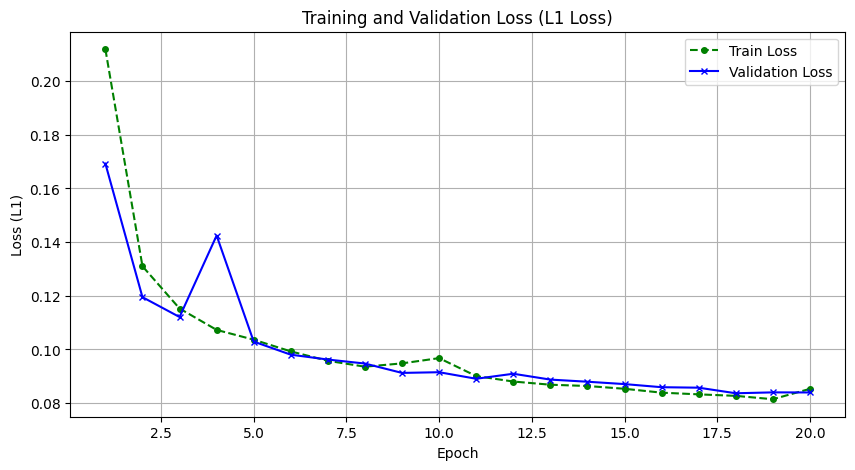

In [ ]:
# (This is the main training/saving cell, modified for L1 Loss)

import torch
import torch.nn as nn
import torch.optim as optim
import random
import os
import matplotlib.pyplot as plt # 👈 1. 그래프를 위한 임포트

# --- 1. Import Modules ---
from channels import awgn_channel
from face_autoencoder import FaceAutoencoder

# (We assume train_loader and val_loader are loaded from the previous cell)

# -----------------------------------------------
# 2. Training Setup
# -----------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 👈 (MODIFIED) 1024 대신 효율적인 512 차원 권장
model = FaceAutoencoder(latent_dim=512).to(device)
# 👈 (MODIFIED) L1 Loss로 변경
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# (Training parameters)
num_epochs = 20
MIN_SNR_DB = 0.0
MAX_SNR_DB = 20.0

# (Save paths)
SAVE_DIR = "/content/drive/MyDrive/models"
# 👈 (MODIFIED) 새 모델 경로
MODEL_PATH = os.path.join(SAVE_DIR, "face_autoencoder_512_L1.pth")
os.makedirs(SAVE_DIR, exist_ok=True)

best_val_loss = float('inf')

# 👈 2. Loss 히스토리 리스트 초기화
train_loss_history = []
val_loss_history = []

# -----------------------------------------------
# 3. Training Loop (with Validation)
# -----------------------------------------------
print("Starting robust training (L1 Loss)...") # 👈 (MODIFIED) 로그 변경
SNR_POINTS_FOR_VAL = [0.0, 5.0, 10.0, 15.0, 20.0]
NUM_VAL_POINTS = len(SNR_POINTS_FOR_VAL)

for epoch in range(num_epochs):

    # --- (A) Training Phase ---
    model.train()
    total_train_loss = 0

    for images, _ in train_loader:
        images = images.to(device)

        # 1. Encode
        latent_vector = model.encode(images)

        # 2. Channel (Apply random SNR for robust training)
        current_snr_db = random.uniform(MIN_SNR_DB, MAX_SNR_DB)
        noisy_vector = awgn_channel(latent_vector, snr_db=current_snr_db)

        # 3. Decode
        reconstructed_images = model.decode(noisy_vector)

        # 4. Loss (L1 Loss가 적용됨)
        loss = criterion(reconstructed_images, images)

        # 5. Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)

    # --- (B) Validation Phase (Robustness Evaluation) ---
    model.eval()
    total_combined_loss = 0

    with torch.no_grad():
        for val_images, _ in val_loader:
            val_images = val_images.to(device)

            for fixed_snr_db in SNR_POINTS_FOR_VAL:
                latent_vector = model.encode(val_images)
                noisy_vector = awgn_channel(latent_vector, snr_db=fixed_snr_db)
                reconstructed_images = model.decode(noisy_vector)

                # 4. Loss (L1 Loss가 적용됨)
                val_loss = criterion(reconstructed_images, val_images)
                total_combined_loss += val_loss.item()

    avg_val_loss = total_combined_loss / (len(val_loader) * NUM_VAL_POINTS)

    # 👈 3. Loss 히스토리 저장
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)

    # --- (C) Log and Save Best Model ---
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        print(f" -> New best validation loss! Saving model to {MODEL_PATH}")
        torch.save(model.state_dict(), MODEL_PATH)

print("--- Training finished. ---")
print(f"Best validation loss achieved: {best_val_loss:.6f}")
print(f"Best model saved to {MODEL_PATH}")

# -----------------------------------------------
# 4. 👈 (NEW) 4. 훈련 완료 후 Loss 그래프 출력
# -----------------------------------------------
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, label='Train Loss',
         linestyle='--', color='green', marker='o', markersize=4)
plt.plot(range(1, num_epochs + 1), val_loss_history, label='Validation Loss',
         linestyle='-', color='blue', marker='x', markersize=4)
plt.xlabel('Epoch')
plt.ylabel('Loss (L1)')
plt.title('Training and Validation Loss (L1 Loss)')
plt.legend()
plt.grid(True)
plt.show()